# Ödometerversuch
## Grundlagen
In diesem Tutorial wird ein einfaches ODE-Problem ohne Randbedingungen betrachtet. Das Problem ist wie folgt definiert:
$$
\text{Problem } x
$$

Trainingsdaten werden aus der aktuellen Excelliste entnommen.

In [18]:
import pandas as pd
import numpy as np
from sympy.integrals.heurisch import components

# Excel-Datei laden (ersetze 'datei.xlsx' mit deinem Dateinamen)
file_path = "data/oedometer/oedo_trainingsdata.xlsx"
sheet_name = "Res"

# Excel-Datei mit explizitem Tabellenblatt laden
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Dynamische Ermittlung der letzten Zeile mit Daten
row_start_range = 0  # Startet bei Zeile 6 (0-basiert)
row_end_range = df.dropna(how="all").last_valid_index() + 1  # Letzte Zeile mit Daten

# Spaltenauswahl (drei nicht nebeneinanderliegende Spalten, z. B. Spalte B, D und F)
selected_columns = [1, 3, 5]  # Spalten-Indices

# Daten extrahieren (nur die gewünschten Spalten)
data_subset = df.iloc[row_start_range:row_end_range, selected_columns]

# Dictionary with column names as keys and torch.tensor as values, converting all values to float
data_dict = {col: np.array(data_subset[col]) for col in data_subset.columns}
print(data_dict)

{'sigma_0': array([1.00000000e+00, 1.20000000e+00, 1.44000000e+00, 1.72800000e+00,
       2.07360000e+00, 2.48832000e+00, 2.98598400e+00, 3.58318080e+00,
       4.29981696e+00, 5.15978035e+00, 6.19173642e+00, 7.43008371e+00,
       8.91610045e+00, 1.06993205e+01, 1.28391846e+01, 1.54070216e+01,
       1.84884259e+01, 2.21861111e+01, 2.66233333e+01, 3.19479999e+01,
       3.83375999e+01, 4.60051199e+01, 5.52061439e+01, 6.62473727e+01,
       7.94968472e+01, 9.53962166e+01, 1.14475460e+02, 1.37370552e+02,
       1.64844662e+02, 1.97813595e+02, 2.37376314e+02, 2.84851577e+02,
       3.41821892e+02, 4.10186270e+02, 4.92223524e+02, 5.90668229e+02,
       7.08801875e+02, 8.50562250e+02, 1.02067470e+03, 1.22480964e+03,
       1.46977157e+03, 1.76372588e+03, 2.11647106e+03, 2.53976527e+03,
       3.04771832e+03, 3.65726199e+03, 4.38871439e+03, 5.26645726e+03,
       6.31974872e+03, 7.58369846e+03, 9.10043815e+03, 1.09205258e+04,
       1.31046309e+04, 1.57255571e+04, 1.88706685e+04, 2.26448023

## Konvertierung zu LabelTensor

In [19]:
import torch
from pina.utils import LabelTensor
from torch import tensor

# Beispiel-Daten, die du aus deinem data_dict extrahiert hast
sigma_0_train = LabelTensor(tensor(data_dict['sigma_0'], dtype=torch.float).unsqueeze(-1), ['sigma_0'])
delta_epsilon_train = LabelTensor(tensor(data_dict['delta_epsilon'], dtype=torch.float).unsqueeze(-1), ['delta_epsilon'])
sigma_1_train = LabelTensor(tensor(data_dict['sigma_1'], dtype=torch.float).unsqueeze(-1), ['sigma_1'])

# Stelle sicher, dass die Labels übereinstimmen, wenn sie zusammengeführt werden
# Wir stapeln sigma_0_train und delta_epsilon_train
input_points_combined = LabelTensor(tensor([data_dict['sigma_0'], data_dict['delta_epsilon']], dtype=torch.float).mT, ['sigma_0', 'delta_epsilon'])

print('Data Loaded')
print(f' sigma_0: {sigma_0_train.size()}')
print(f' delta_epsilon: {delta_epsilon_train.shape}')
print(f' sigma_0 und delta_epsilon combined: {input_points_combined.size()}')
print(f' sigma_1: {sigma_1_train.shape}')


Data Loaded
 sigma_0: torch.Size([493, 1])
 delta_epsilon: torch.Size([493, 1])
 sigma_0 und delta_epsilon combined: torch.Size([493, 2])
 sigma_1: torch.Size([493, 1])


In [20]:
from pina.problem import AbstractProblem
from pina.geometry import CartesianDomain
from pina import Condition
class SimpleODE(AbstractProblem):

    # Korrekte Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = input_points_combined.labels
    output_variables = sigma_1_train.labels

    domain = CartesianDomain({'sigma_0': [0, 10], 'delta_epsilon': [0, 1]})  # CartesianDomain ohne spezifizierte Werte, da es über die Eingabepunkte festgelegt wird

    conditions = {
        'data': Condition(input_points=input_points_combined, output_points=sigma_1_train),
    }

    output_pts=sigma_1_train

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['sigma_0']))

# Problem-Instanz erzeugen
problem = SimpleODE()

# Debugging-Ausgaben
print("Geladene Input Variablen: ", problem.input_variables)
print("Geladene Output Variablen: ", problem.output_variables)

print('Input points:', problem.input_pts)

Geladene Input Variablen:  ['sigma_0', 'delta_epsilon']
Geladene Output Variablen:  ['sigma_1']
Input points: {'data': LabelTensor([[[1.0000e+00, 5.0000e-04]],
             [[1.2000e+00, 5.0000e-04]],
             [[1.4400e+00, 5.0000e-04]],
             [[1.7280e+00, 5.0000e-04]],
             [[2.0736e+00, 5.0000e-04]],
             [[2.4883e+00, 5.0000e-04]],
             [[2.9860e+00, 5.0000e-04]],
             [[3.5832e+00, 5.0000e-04]],
             [[4.2998e+00, 5.0000e-04]],
             [[5.1598e+00, 5.0000e-04]],
             [[6.1917e+00, 5.0000e-04]],
             [[7.4301e+00, 5.0000e-04]],
             [[8.9161e+00, 5.0000e-04]],
             [[1.0699e+01, 5.0000e-04]],
             [[1.2839e+01, 5.0000e-04]],
             [[1.5407e+01, 5.0000e-04]],
             [[1.8488e+01, 5.0000e-04]],
             [[2.2186e+01, 5.0000e-04]],
             [[2.6623e+01, 5.0000e-04]],
             [[3.1948e+01, 5.0000e-04]],
             [[3.8338e+01, 5.0000e-04]],
             [[4.600

## Visualisierung Sampling
Darstellung Input: `sigma_0` und `delta_epsilon`

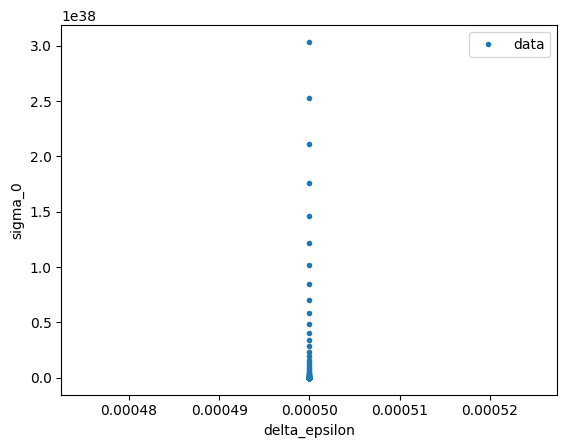

In [21]:
from pina import Plotter

pl = Plotter()
pl.plot_samples(problem=problem, variables=['delta_epsilon','sigma_0'])

In [ ]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
import torch

# Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
print("Länge der Eingabepunkte (input_pts):", len(problem.input_pts['data']))
print("Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))


# build the model
model = FeedForward(
    layers=[10, 10],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# create the PINN object
pinn = PINN(problem, model)

# create the trainer
trainer = Trainer(solver=pinn,
                  max_epochs=100,
                  callbacks=[MetricTracker()],
                  batch_size=1,
                  accelerator='cpu',
                  enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)
# train
trainer.train()

## inspecting final loss
trainer.logged_metrics

Länge der Eingabepunkte (input_pts): 493
Länge der Ausgabepunkte (output_pts): 493


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

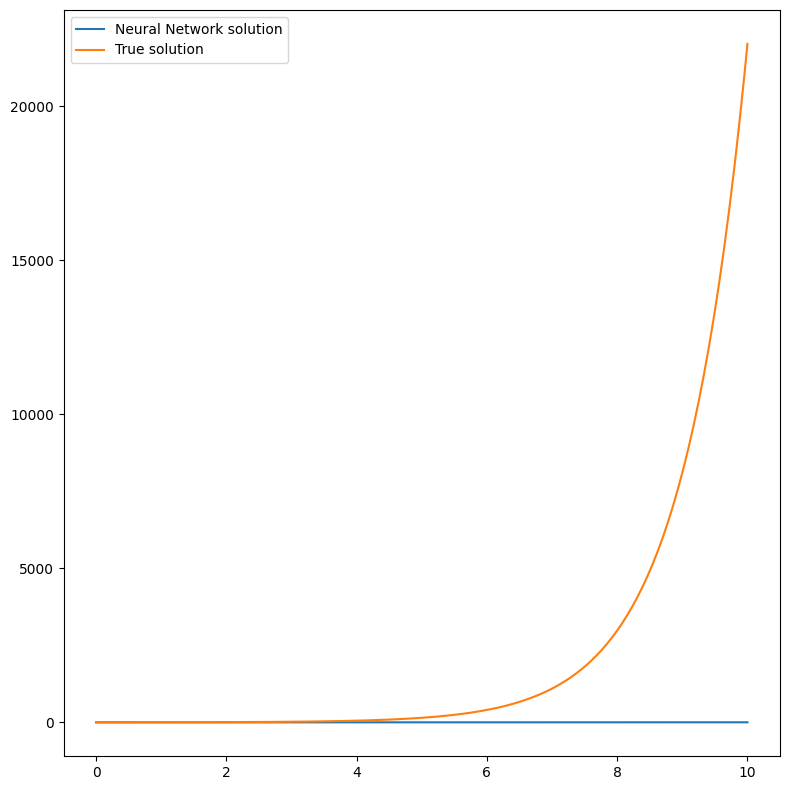

In [16]:
pl.plot(solver=pinn, fixed_variables={'delta_epsilon' : 0.0005}, components=['sigma_1'])

## Visualisierung Loss-Kurve


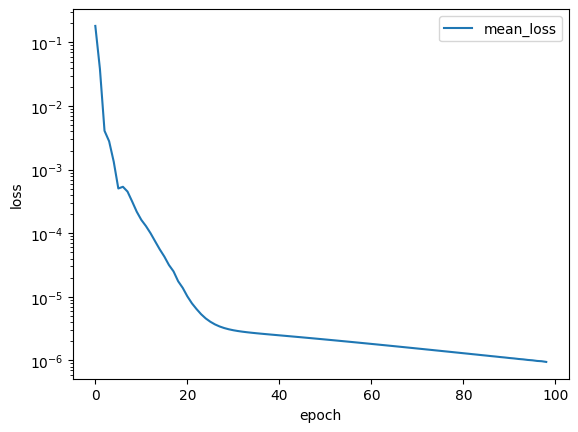

In [9]:
# plotting the solution
pl.plot_loss(trainer, label='mean_loss', logy=True)